# Exploring Narrative Agency in Women’s Fiction (1800–1950)

This notebook investigates how female characters are represented in fiction written by women (and select pseudonyms) between 1800 and 1950. Drawing on Natural Language Processing (NLP), we aim to quantify and visualize **narrative agency** — the capacity of characters to act, decide, or influence events — as reflected through the verbs and grammatical structures used in the text.

### Objectives

- **Extract subject–verb pairs** to identify who is acting, and what actions they are associated with.
- **Classify verbs by agency level** (high, low, or neutral) using both symbolic and embedding-based methods.
- **Normalize and visualize agency patterns** across characters, highlighting how gendered roles are linguistically constructed.
- **Compare male and female characters** to detect stylistic and thematic trends in feminist literary history.

We begin with _Pride and Prejudice_ as a test case, with the goal of scaling the analysis to a broader corpus of historical fiction. This work forms part of a larger exploration of feminist themes, authorship, and linguistic agency in 19th- and early 20th-century literature.


In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Library Imports

This cell imports all the core libraries required for preprocessing, linguistic parsing, and analysis.


In [98]:
import pandas as pd
import spacy
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

## Load spaCy Language Model

spaCy is a lightweight NLP library used to process raw text and extract linguistic information.  
In our case, we use it for:

- **Tokenization**: Splits text into words and punctuation  
- **Part-of-Speech (POS) Tagging**: Identifies grammatical roles (e.g., noun, verb)  
- **Dependency Parsing**: Finds subject–verb relationships  
- **Named Entity Recognition (NER)**: Detects person names and titles

**Example**:  
For the sentence `"Mr. Darcy smiled at Elizabeth."`, spaCy provides:

- Tokens: `["Mr.", "Darcy", "smiled", "at", "Elizabeth", "."]`  
- POS tags: `Darcy → PROPN`, `smiled → VERB`  
- Dependency: `Darcy` is the subject (`nsubj`) of `smiled`  
- NER: `"Mr. Darcy"` and `"Elizabeth"` are both `PERSON` entities

We begin by loading the `en_core_web_sm` model from [spaCy](https://spacy.io/), a popular NLP library. Although this model does not include word vectors (required for semantic similarity tasks), it is fast and accurate enough for syntactic tasks like extracting subject–verb pairs.

In [99]:
nlp = spacy.load("en_core_web_sm")
print("spaCy model loaded!")

spaCy model loaded!


## Load the dataset

We load a preprocessed dataset of literary text chunks into a DataFrame.

Each row corresponds to a distinct passage (`chunk`) from a work of fiction, annotated with metadata:

- `chunk`: a paragraph or narrative unit of text
- `title`: the title of the book
- `author`: the author's full name
- `year`: year of publication
- `chunk_id`: a unique identifier for each chunk (useful for tracking and re-merging)

This structure allows for both linguistic analysis at the sentence level and aggregation at the book, author, or decade level.

In [100]:
df = pd.read_csv(r"/content/drive/MyDrive/AI project/processed_book_chunks.csv")
df.head()

,chunk,title,author,year,chunk_id
0,CHAPTER 1.\nA Not Unnatural Enterprise This is...,Herland,Charlotte Perkins Gilman,1915,CP_001
1,The expedition was up among the thousand tribu...,Herland,Charlotte Perkins Gilman,1915,CP_002
2,It was early yet; we had just breakfasted; and...,Herland,Charlotte Perkins Gilman,1915,CP_003
3,“Woman Country--up\nthere.” Then we were inter...,Herland,Charlotte Perkins Gilman,1915,CP_004
4,"It had a special covering of fitted armor, thi...",Herland,Charlotte Perkins Gilman,1915,CP_005


## Scope of the Analysis

This notebook focuses on a selected subset of books from the full dataset rather than processing the entire corpus at once.

There are several reasons for this design choice:

- **Exploratory phase**: Initial development benefits from faster iteration on smaller, well-understood examples like _Pride and Prejudice_ or _Herland_.
- **Computational cost**: Full parsing, coreference resolution, and verb classification are resource-intensive. Limiting to a few texts allows for deeper linguistic analysis without overloading memory or runtime limits.
- **Debugging and validation**: Working with known examples helps verify that named entity recognition, subject–verb extraction, and character mapping are functioning correctly before scaling up.
- **Qualitative control**: Focusing on books with strong feminist themes or well-known characters provides better context for interpreting agency patterns.

Once the methodology is validated, the same pipeline can be applied to the broader dataset to produce comparative insights across authors and time periods.

# PRIDE AND PREJUDICE

One of the first texts analyzed in depth is _Pride and Prejudice_ by Jane Austen.

There are several reasons we began with this novel:

- **Canonical status**: _Pride and Prejudice_ is one of the most widely studied works in English literature and feminist criticism. Its characters, themes, and narrative style are well-documented, which makes it a reliable reference point for testing our pipeline.

- **Rich character structure**: The novel features a wide range of characters with clearly defined personalities, roles, and social positions. This variety makes it especially useful for examining how different individuals are granted (or denied) agency in the narrative.

- **Balance of dialogue and narration**: Austen combines third-person narration with frequent character-driven dialogue. This allows us to evaluate how well our system performs across different types of narrative structure, from descriptive passages to direct speech.

- **Cultural familiarity**: Because the novel is so well known, it’s easier to interpret and validate the patterns we extract. We can more confidently assess whether the results make sense — both linguistically and narratively.

Starting with _Pride and Prejudice_ helps us refine our approach, verify that each component of the pipeline works as expected, and build a strong foundation for applying the same analysis to the rest of the dataset.


In [101]:
df_pp = df[df["title"] == "Pride and Prejudice"].copy()

In [102]:
df_pp.head()

,chunk,title,author,year,chunk_id
2881,Chapter I. It is a truth universally acknowled...,Pride and Prejudice,Jane Austen,1813,JA_001
2882,Sir William and Lady Lucas are determined to g...,Pride and Prejudice,Jane Austen,1813,JA_002
2883,"“But you forget, mamma,” said Elizabeth, “that...",Pride and Prejudice,Jane Austen,1813,JA_003
2884,I was sure you loved your girls too well to\nn...,Pride and Prejudice,Jane Austen,1813,JA_004
2885,Mr. Bingley\nwas obliged to be in town the fol...,Pride and Prejudice,Jane Austen,1813,JA_005


We define a function that extracts character names from a block of text, including any honorifics or titles attached to them.

It uses spaCy’s named entity recognition to identify `PERSON` entities, and then checks if a known title (like "Mr.", "Miss", or "Lady") appears immediately before the name in the text. If so, it combines the title and name (e.g., "Mr. Darcy"); otherwise, it just uses the name itself.

This step helps preserve important information about social status, gender, and formality, which often come encoded in how characters are referred to — especially in 19th-century fiction.


In [103]:
def extract_names_with_titles(text):
    doc = nlp(text)
    known_titles = {"Mr.", "Mrs.", "Miss", "Ms.", "Dr.", "Sir", "Lady", "Lord"}

    full_names = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            start = ent.start
            if start > 0 and doc[start - 1].text in known_titles:
                full_name = f"{doc[start - 1].text} {ent.text}"
                full_names.append(full_name)
            else:
                full_names.append(ent.text)
    return full_names


Run a quick test of the `extract_names_with_titles` function on a simple sentence.


In [104]:
extract_names_with_titles("Mr. Darcy and Elizabeth walked together.")


['Mr. Darcy', 'Elizabeth']

Apply the `extract_names_with_titles` function to each text chunk in the dataset.

In [105]:
df_pp["person_names"] = df_pp["chunk"].apply(extract_names_with_titles)

In [106]:
df_pp.head(20)

,chunk,title,author,year,chunk_id,person_names
2881,Chapter I. It is a truth universally acknowled...,Pride and Prejudice,Jane Austen,1813,JA_001,"[Chapter I. It, Mr. Bennet, Mr. Bennet, Mrs. L..."
2882,Sir William and Lady Lucas are determined to g...,Pride and Prejudice,Jane Austen,1813,JA_002,"[Sir William, Lady Lucas, Mr. Bingley, Lizzy, ..."
2883,"“But you forget, mamma,” said Elizabeth, “that...",Pride and Prejudice,Jane Austen,1813,JA_003,"[Elizabeth, Mrs. Long, Mrs. Long, Mr. Bennet, ..."
2884,I was sure you loved your girls too well to\nn...,Pride and Prejudice,Jane Austen,1813,JA_004,"[Kitty, Mr. Bennet, Mr. Bingley, Mr. Bennet, M..."
2885,Mr. Bingley\nwas obliged to be in town the fol...,Pride and Prejudice,Jane Austen,1813,JA_005,"[Mr. Bingley, Mrs. Bennet, Lady Lucas, George ..."
2886,Amongst the most violent against him was Mrs. ...,Pride and Prejudice,Jane Austen,1813,JA_006,"[Mrs. Bennet, Elizabeth Bennet, Mr. Darcy, Mr...."
2887,"They returned, therefore, in good\nspirits to ...",Pride and Prejudice,Jane Austen,1813,JA_007,"[Mr. Bennet, Mr. Bennet, Jane, Mr. Bingley, Mi..."
2888,"When Jane and Elizabeth were alone, the former...",Pride and Prejudice,Jane Austen,1813,JA_008,"[Jane, Elizabeth, Mr. Bingley, Elizabeth, Miss..."
2889,They were rather handsome; had been educated i...,Pride and Prejudice,Jane Austen,1813,JA_009,"[Mr. Bingley, Mr. Bingley, Miss Bingley, Mrs. ..."
2890,"Darcy, on the contrary, had seen a collection ...",Pride and Prejudice,Jane Austen,1813,JA_010,"[Mrs. Hurst, Miss Bennet, George Allen, Sir Wi..."


Define a small utility to clean and normalize character names.

It removes possessive markers like "’s" and collapses any double spaces, ensuring that names like `"Mr. Bennet’s"` become `"Mr. Bennet"`. This step helps reduce duplicates and inconsistencies when counting or grouping character names across the dataset.

In [107]:
def normalize_name_with_title(name):
    name = name.strip().replace("’s", "")
    name = name.replace("  ", " ")
    return name


The result is stored in a new column, `person_names_cleaned`, which holds a cleaned and deduplicated list of character names for every chunk. This makes later steps like frequency counting and gender inference more reliable.

In [108]:
df_pp["person_names_cleaned"] = df_pp["person_names"].apply(
    lambda names: list(set(normalize_name_with_title(n) for n in names))
)

In [109]:
df_pp["person_names_cleaned"].explode().value_counts().head(100)

,count
person_names_cleaned,
Elizabeth,222
Jane,131
Mr. Darcy,125
Mrs. Bennet,77
Wickham,68
...,...
Lizzie,2
Mrs. Reynolds,2
Clapham,2


Display the 100 most frequently mentioned character names across all text chunks, based on the cleaned and normalized name list.

The column `person_names_cleaned` is exploded to create one row per name mention, and then counted with `value_counts()`. This gives a global frequency distribution of character references in the text.

The top results show what we would expect: "Elizabeth" is the most frequently mentioned character, followed by "Jane" and "Mr. Darcy". This aligns with their narrative prominence in _Pride and Prejudice_, suggesting that the name extraction and normalization steps are capturing key figures accurately.


Tallies the total number of times each character is mentioned in the dataset.

Iterates through the cleaned name lists (`person_names_cleaned`) and updates a `Counter` to track how many times each name appears across all chunks.  
The result is stored in `df_char_freq`, a DataFrame listing all character names along with their overall mention count, sorted from most to least frequent.

In [110]:
char_counter = Counter()
for names in df_pp["person_names_cleaned"]:
    char_counter.update(names)

df_char_freq = pd.DataFrame(char_counter.items(), columns=["Name", "Count"]).sort_values("Count", ascending=False)


In [111]:
df_char_freq

,Name,Count
12,Elizabeth,222
8,Jane,131
16,Mr. Darcy,125
14,Mrs. Bennet,77
76,Wickham,68
...,...,...
159,Mr. Darcy!--and,1
160,Sarah,1
161,Console Lady Catherine,1
162,Mrs. Darcy,1


Filter out spurious or non-character entries from the character frequency table.

The `is_valid_character` function applies a set of rules to remove noisy or irrelevant name entries. It excludes:
- Very short strings,
- Strings containing numbers,
- Generic tokens like "Chapter" or "Said",
- Names that appear to be formatting artifacts or isolated initials.

This step ensures that `df_char_freq` includes only meaningful character names, improving the quality of our later analysis.

In [112]:
def is_valid_character(name):
    #discard names that are too short, clearly formatting, or noise
    if len(name) < 3:
        return False
    if re.search(r"\d", name):  #contains numbers
        return False
    if name.lower() in {"chapter", "said", "mrs", "mr", "miss"}:  #too generic
        return False
    if name.startswith(("Chapter", "PRIDE", "XV", "GEORGE SAINTSBURY")):
        return False
    if re.match(r"^[A-Z]$", name.strip()):
        return False
    return True

#filter junk rows
df_char_freq = df_char_freq[df_char_freq["Name"].apply(is_valid_character)].copy()


In [113]:
df_char_freq.head(20)

,Name,Count
12,Elizabeth,222
8,Jane,131
16,Mr. Darcy,125
14,Mrs. Bennet,77
76,Wickham,68
61,Mr. Collins,60
1,Mr. Bingley,59
22,Darcy,57
9,Lizzy,56
7,Mr. Bennet,52


Standardize character names by manually mapping common variants and aliases to their canonical forms.

For example, different references to Elizabeth such as "Miss Elizabeth", "Eliza", and "Lizzy" are all mapped to `"Elizabeth"`. Similarly, "Darcy", "Fitzwilliam", and "Mr. Darcy" are unified under `"Mr. Darcy"`.

This step addresses name duplication caused by titles, nicknames, or alternate forms. We chose to do this manually, since we are working with a relatively small number of key characters, and a handcrafted mapping ensures high precision and interpretability.

The result is a cleaner, more accurate frequency table that reflects the true prominence of each character in the narrative.


In [114]:
name_map = {
    "Lizzy": "Elizabeth",
    "Miss Bennet": "Elizabeth",
    "Miss Elizabeth": "Elizabeth",
    "Miss Eliza":"Elizabeth",
    "Eliza": "Elizabeth",
    "George Wickham": "Mr. Wickham",
    "Wickham" : "Mr. Wickham",
    "Lady Catherine": "Catherine",
    "Lady Catherine de Bourgh": "Catherine",
    "Miss De Bourgh": "Catherine",
    "Miss Lucas": "Charlotte",
    "Charlotte Lucas": "Charlotte",
    "Jane Bennet": "Jane",
    "Bingley": "Mr. Bingley",
    "Fitzwilliam" : "Mr. Darcy",
    "Darcy" : "Mr. Darcy",
    "Elizabeth Bennet": "Elizabeth",
    "Collins" : "Mr. Collins",
    "Sir William Lucas" : "Sir William",
    "Sir William" : "Sir William"

}

df_char_freq["Name"] = df_char_freq["Name"].replace(name_map)

Group together all rows with the same canonical name and sums their counts.

In [115]:
df_char_freq = (
    df_char_freq.groupby("Name", as_index=False)
    .agg({"Count": "sum"})
    .sort_values("Count", ascending=False)
)

In [116]:
df_char_freq

,Name,Count
25,Elizabeth,307
89,Mr. Darcy,197
43,Jane,131
101,Mr. Wickham,113
87,Mr. Bingley,99
...,...,...
135,"again,--",1
138,inn,1
139,kindest,1
141,uncle Philips,1


As a first step in our gender classification, we assign a gender label to each character name based on common English titles.

Names starting with titles like "Mr.", "Sir", or "Lord" are labeled as `"male"`, while names beginning with "Mrs.", "Miss", "Ms.", or "Lady" are labeled as `"female"`. If no recognizable title is present, the gender is left as `None`.

In [117]:
def infer_gender_from_title(name):
    name = name.strip()

    male_titles = ("Mr.", "Sir", "Lord", "Monsieur", "Dr.", "Doctor")
    female_titles = ("Mrs.", "Miss", "Ms.", "Lady", "Madame", "Mademoiselle")

    if name.startswith(male_titles):
        return "male"
    elif name.startswith(female_titles):
        return "female"
    else:
        return None


df_char_freq["Gender"] = df_char_freq["Name"].apply(infer_gender_from_title)

In [118]:
df_char_freq.head(20)

,Name,Count,Gender
25,Elizabeth,307,None
89,Mr. Darcy,197,male
43,Jane,131,None
101,Mr. Wickham,113,male
87,Mr. Bingley,99,male
103,Mrs. Bennet,77,female
12,Catherine,73,None
88,Mr. Collins,72,male
86,Mr. Bennet,52,male
77,Miss Bingley,43,female


As a second step, we also look at the rest of the characters.

Get all the characters with 'unknown labeled gender'

In [119]:
unlabeled = df_char_freq[df_char_freq["Gender"] == "unknown"]

Filter for names without titles.

In [120]:
def has_title(name):
    return any(title in name for title in ["Mr.", "Mrs.", "Miss", "Lady", "Sir", "Dr.", "Lord"])

unlabeled_names = unlabeled[~unlabeled["Name"].apply(has_title)]


Manually fill in missing gender labels for key characters that couldn't be inferred from titles.

Since the dataset contains a limited number of recurring characters, we chose not to rely on an automated gender prediction tool. Instead, we created a manual mapping for names like "Elizabeth", "Jane", and "Wickham" based on known character identities.

In [121]:
manual_gender_map = {
    "Elizabeth": "female",
    "Jane": "female",
    "Charlotte": "female",
    "Catherine": "female",
    "Lydia": "female",
    "Kitty": "female",
    "Wickham": "male",
    "Bingley": "male",
    "Collins": "male",
    "Fitzwilliam": "male",
    "Mary": "female",
    "Austen": "female",
    "Lizzy":"female"
}

df_char_freq["Gender"] = df_char_freq["Gender"].fillna(df_char_freq["Name"].map(manual_gender_map))

In [122]:
df_char_freq

,Name,Count,Gender
25,Elizabeth,307,female
89,Mr. Darcy,197,male
43,Jane,131,female
101,Mr. Wickham,113,male
87,Mr. Bingley,99,male
...,...,...,...
135,"again,--",1,NaN
138,inn,1,NaN
139,kindest,1,NaN
141,uncle Philips,1,NaN


# Verb Extraction

With the character names cleaned, normalized, and labeled by gender, we now move on to extracting verbs associated with those characters.

This next step focuses on identifying subject–verb pairs in the text, which will allow us to analyze what actions characters are described as performing — a key part of measuring narrative agency.

Create a set of all cleaned character names in lowercase.

This set is used later to help match character mentions in the text with known character identities, regardless of capitalization.  


In [123]:
known_names = set(name.lower() for name in df_char_freq["Name"])

Define a function to extract subject–verb pairs with a focus on female characters.

For each sentence in the text, the function identifies verbs and their grammatical subjects. If the subject matches a known female name, the verb is paired with that name. If the subject is a pronoun like "she" or "her", the function uses the most recently seen female name (`last_female`) as a proxy.

This is a lightweight workaround for coreference resolution, allowing the system to attribute actions to the correct character even when pronouns are used. The output is a list of (character, verb) pairs for each chunk of text.


In [124]:
nlp = spacy.load("en_core_web_sm")

def extract_character_verb_pairs_smart(text, known_female_names):
    doc = nlp(text)
    last_female = None
    pairs = []

    for sent in doc.sents:
        for token in sent:
            if token.pos_ == "VERB":
                subjects = [child for child in token.children if child.dep_ in ("nsubj", "nsubjpass")]
                for subj in subjects:
                    name = subj.text.lower()
                    if name in known_female_names:
                        last_female = name
                        pairs.append((name, token.lemma_.lower()))
                    elif name in {"she", "her"} and last_female:
                        pairs.append((last_female, token.lemma_.lower()))
    return pairs


In [125]:
tqdm.pandas()

df_pp["verb_pairs"] = df_pp["chunk"].progress_apply(lambda x: extract_character_verb_pairs_smart(x, known_names))


100%|██████████| 253/253 [00:17<00:00, 14.63it/s]


In [126]:
df_pp.head(20)

,chunk,title,author,year,chunk_id,person_names,person_names_cleaned,verb_pairs
2881,Chapter I. It is a truth universally acknowled...,Pride and Prejudice,Jane Austen,1813,JA_001,"[Chapter I. It, Mr. Bennet, Mr. Bennet, Mrs. L...","[Mrs. Long, Mr. Bingley, Netherfield, Michaelm...","[(lady, say), (lady, return), (lady, tell), (n..."
2882,Sir William and Lady Lucas are determined to g...,Pride and Prejudice,Jane Austen,1813,JA_002,"[Sir William, Lady Lucas, Mr. Bingley, Lizzy, ...","[Mr. Bingley, Jane, George Allen, Mr. Bennet, ...",[]
2883,"“But you forget, mamma,” said Elizabeth, “that...",Pride and Prejudice,Jane Austen,1813,JA_003,"[Elizabeth, Mrs. Long, Mrs. Long, Mr. Bennet, ...","[Mrs. Long, Mr. Bingley, Elizabeth, Kitty, Mrs...","[(elizabeth, say), (elizabeth, have), (elizabe..."
2884,I was sure you loved your girls too well to\nn...,Pride and Prejudice,Jane Austen,1813,JA_004,"[Kitty, Mr. Bennet, Mr. Bingley, Mr. Bennet, M...","[Mr. Bingley, Kitty, Mrs. Bennet, Mr. Bennet, ...","[(lydia, say), (lydia, say)]"
2885,Mr. Bingley\nwas obliged to be in town the fol...,Pride and Prejudice,Jane Austen,1813,JA_005,"[Mr. Bingley, Mrs. Bennet, Lady Lucas, George ...","[Mr. Darcy, Mr. Bingley, Mrs. Hurst, Miss Bing...","[(hurst, look), (darcy, dance)]"
2886,Amongst the most violent against him was Mrs. ...,Pride and Prejudice,Jane Austen,1813,JA_006,"[Mrs. Bennet, Elizabeth Bennet, Mr. Darcy, Mr....","[Mr. Darcy, Bingley, Mr. Bingley, Elizabeth, N...","[(darcy, stand), (darcy, overhear), (darcy, sa..."
2887,"They returned, therefore, in good\nspirits to ...",Pride and Prejudice,Jane Austen,1813,JA_007,"[Mr. Bennet, Mr. Bennet, Jane, Mr. Bingley, Mi...","[Mr. Darcy, Mr. Bingley, Maria Lucas, Mrs. Hur...",[]
2888,"When Jane and Elizabeth were alone, the former...",Pride and Prejudice,Jane Austen,1813,JA_008,"[Jane, Elizabeth, Mr. Bingley, Elizabeth, Miss...","[Jane, Mr. Bingley, Elizabeth, Miss Bingley]","[(elizabeth, reply), (elizabeth, listen)]"
2889,They were rather handsome; had been educated i...,Pride and Prejudice,Jane Austen,1813,JA_009,"[Mr. Bingley, Mr. Bingley, Miss Bingley, Mrs. ...","[Bingley, Mr. Bingley, Mrs. Hurst, Miss Bingle...","[(darcy, give)]"
2890,"Darcy, on the contrary, had seen a collection ...",Pride and Prejudice,Jane Austen,1813,JA_010,"[Mrs. Hurst, Miss Bennet, George Allen, Sir Wi...","[Longbourn, Mr. Bingley, Sir William Lucas, Mr...","[(darcy, see), (darcy, smile), (hurst, allow)]"


Collects all character names that appear in the extracted (character, verb) pairs and compares them to the cleaned list of known characters.

By exploding the `verb_pairs` column and isolating the character in each pair, the code creates a set of all names that were actually linked to actions in the text.  
It then compares this set to `df_char_freq["Name"]` to identify any names that were extracted during parsing but never appeared in the earlier frequency table.

This check helps catch:
- characters missed during earlier cleaning or alias mapping,
- pronouns or informal references not yet resolved,
- and parsing artifacts that may need to be filtered out.

It’s mainly used to validate coverage and alignment between the character recognition and verb pairing stages.

In [127]:
#collect all character names used in verb_pairs
all_names = set()

for row in df_pp["verb_pairs"].dropna().explode():
    if isinstance(row, tuple) and len(row) == 2:
        char, _ = row
        all_names.add(char)

#compare to cleaned character list
cleaned_names = set(df_char_freq["Name"])
unused_names = all_names - cleaned_names

print("Characters in verb_pairs not in df_char_freq:", unused_names)


Characters in verb_pairs not in df_char_freq: {'lady', 'mary', 'louisa', 'hill', 'gardiner', 'rosings', 'caroline', 'catherine', 'denny', 'haggerston', 'forster', 'charles', 'maria', 'elizabeth', 'jane', 'hurst', 'pemberley', 'collinses', 'away', 'lydia', 'kitty', 'gardiners', 'meryton', 'john', 'sarah', 'netherfield', 'william', 'mamma', 'darcy', 'jenkinson', 'charlotte'}


## VerbNet Classification

Now that we have extracted (character, verb) pairs from the text, we can begin analyzing agency by assigning each verb a label — `"high"`, `"neutral"`, or `"low"` — based on the kind of action it represents.

To do this, we use VerbNet, a verb classification resource developed for computational linguistics. VerbNet groups English verbs into classes based on their syntactic behavior and underlying semantic structure. For example, verbs related to giving, causing, or deciding typically belong to classes that imply control or intention, while those related to emotion or perception may suggest passivity or receptivity.

In this approach, we define three reference sets of verbs:
- **High-agency verbs** (e.g., `"command"`, `"make"`, `"lead"`) imply initiative, decision-making, or power.
- **Low-agency verbs** (e.g., `"suffer"`, `"fear"`, `"want"`) suggest passivity, emotional dependence, or lack of control.
- **Neutral verbs** (e.g., `"say"`, `"walk"`, `"think"`) do not clearly indicate power or submission.

The function attempts to retrieve VerbNet classes for each verb and checks whether any of those classes match our predefined sets. If a match is found, the verb is assigned the corresponding agency level; if not, it defaults to `"neutral"`.

This symbolic classification gives us a structured way to begin evaluating character behavior and agency in the text.


In [128]:
import nltk
nltk.download("verbnet")
from nltk.corpus import verbnet as vn

[nltk_data] Downloading package verbnet to /root/nltk_data...
[nltk_data]   Package verbnet is already up-to-date!


In [129]:
vn_high = {
    'give', 'bring', 'tell', 'force', 'set', 'draw', 'persuade', 'send', 'make',
    'write', 'pass', 'oblige', 'command', 'intend', 'urge', 'ask', 'try', 'pay'
}

vn_low = {
    'cry', 'suffer', 'fear', 'care', 'quit', 'lose', 'wish', 'feel', 'admire',
    'please', 'love', 'bear', 'affect', 'regard', 'want', 'marvel', 'hesitate',
    'need', 'long'
}

vn_neutral = {
    'say', 'mention', 'know', 'think', 'consider', 'read', 'see', 'understand',
    'stand', 'look', 'stay', 'remain', 'seem', 'appear', 'have', 'listen', 'hope',
    'expect', 'remember', 'believe', 'agree', 'find', 'live', 'talk', 'hear',
    'walk', 'return', 'come', 'go'
}



def classify_agency_verbnet(verb):
    try:
        #normalize casing
        verb = verb.lower()

        #get VerbNet classes
        classes = vn.classids(lemma=verb)
        classes = [cls.split("-")[0] for cls in classes]
    except:
        return "neutral"

    for cls in classes:
        if cls in vn_high:
            return "high"
        elif cls in vn_low:
            return "low"
        elif cls in vn_neutral:
            return "neutral"
    return "neutral"


In [130]:
df_pairs = df_pp.explode("verb_pairs")[["verb_pairs"]].dropna()
df_pairs[["Character", "Verb"]] = pd.DataFrame(df_pairs["verb_pairs"].tolist(), index=df_pairs.index)

In [131]:
df_pairs["Agency_VerbNet"] = df_pairs["Verb"].apply(classify_agency_verbnet)

In [132]:
df_pairs

,verb_pairs,Character,Verb,Agency_VerbNet
2881,"(lady, say)",lady,say,neutral
2881,"(lady, return)",lady,return,high
2881,"(lady, tell)",lady,tell,high
2881,"(netherfield, take)",netherfield,take,high
2883,"(elizabeth, say)",elizabeth,say,neutral
...,...,...,...,...
3133,"(darcy, begin)",darcy,begin,neutral
3133,"(darcy, give)",darcy,give,high
3133,"(darcy, send)",darcy,send,high
3133,"(darcy, condescend)",darcy,condescend,neutral


Clean and standardize the character names extracted from subject–verb pairs.

The `Character` column is first lowercased and stripped of surrounding whitespace. Then, all punctuation is removed using a regular expression. The result is stored in a new column, `character_clean`, which contains a simplified version of each name.

This normalization step ensures consistent matching later on — for example, converting `"Mr. Darcy"` to `"mr darcy"` — which improves the reliability of alias resolution and character grouping.


In [133]:
df_pairs["character_clean"] = df_pairs["Character"].str.lower().str.strip()
df_pairs["character_clean"] = df_pairs["character_clean"].str.replace(r"[^\w\s]", "", regex=True)

In [134]:
df_pairs

,verb_pairs,Character,Verb,Agency_VerbNet,character_clean
2881,"(lady, say)",lady,say,neutral,lady
2881,"(lady, return)",lady,return,high,lady
2881,"(lady, tell)",lady,tell,high,lady
2881,"(netherfield, take)",netherfield,take,high,netherfield
2883,"(elizabeth, say)",elizabeth,say,neutral,elizabeth
...,...,...,...,...,...
3133,"(darcy, begin)",darcy,begin,neutral,darcy
3133,"(darcy, give)",darcy,give,high,darcy
3133,"(darcy, send)",darcy,send,high,darcy
3133,"(darcy, condescend)",darcy,condescend,neutral,darcy


In [135]:
df_pairs["Agency_VerbNet"].value_counts()

,count
Agency_VerbNet,
neutral,1671
low,215
high,171


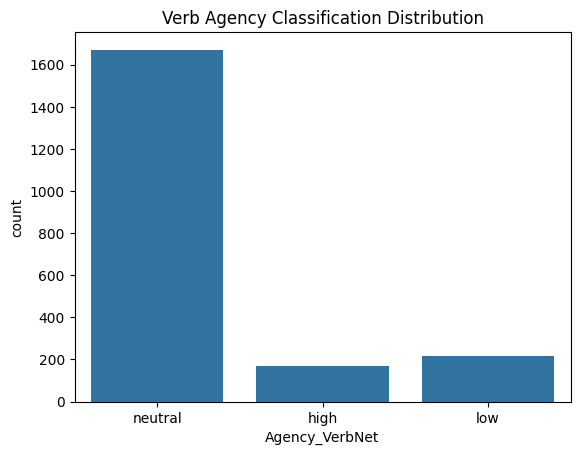

In [136]:
sns.countplot(data=df_pairs, x="Agency_VerbNet")
plt.title("Verb Agency Classification Distribution")
plt.show()

We show the distribution of agency labels assigned using the VerbNet-based classification.

Out of all extracted verbs:
- 1671 are labeled as **neutral**
- 215 are labeled as **low agency**
- 171 are labeled as **high agency**

This skewed distribution suggests that most verbs in the dataset are not strongly agentic or passive. Neutral actions such as "say", "go", or "think" dominate the text, which is typical of narrative fiction where descriptive and communicative verbs are frequent.

It also highlights a limitation of the VerbNet approach: many verbs may fall outside the manually defined sets for high and low agency, leading them to default to neutral. This motivates the need for a more flexible, semantic similarity-based classification in the next step.


In [137]:
df_pairs

,verb_pairs,Character,Verb,Agency_VerbNet,character_clean
2881,"(lady, say)",lady,say,neutral,lady
2881,"(lady, return)",lady,return,high,lady
2881,"(lady, tell)",lady,tell,high,lady
2881,"(netherfield, take)",netherfield,take,high,netherfield
2883,"(elizabeth, say)",elizabeth,say,neutral,elizabeth
...,...,...,...,...,...
3133,"(darcy, begin)",darcy,begin,neutral,darcy
3133,"(darcy, give)",darcy,give,high,darcy
3133,"(darcy, send)",darcy,send,high,darcy
3133,"(darcy, condescend)",darcy,condescend,neutral,darcy


## Distance-Based Classification (Word Embeddings)
This approach uses word embeddings (from spaCy’s medium/large models) to compute the semantic similarity between an extracted verb and a set of reference verbs for each agency type.

Download the `en_core_web_md` model from spaCy, which includes medium-sized word vectors.

Unlike `en_core_web_sm`, this model provides semantic similarity features through pre-trained word embeddings. These vectors are necessary for the next phase of agency classification, where verbs are scored based on their proximity to reference vectors for high, low, and neutral agency.

This model balances reasonable accuracy with manageable resource requirements, making it a good fit for similarity-based verb analysis.


In [138]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 55.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Define three reference sets of verbs — high, low, and neutral — to serve as semantic anchors for agency classification.

Each list contains verbs that are representative of a specific level of narrative agency:
- **High-agency verbs** involve control, intention, or action (e.g., "command", "make", "write").
- **Low-agency verbs** suggest passivity, emotion, or dependence (e.g., "suffer", "need", "wish").
- **Neutral verbs** are common in narration but don’t convey strong agency (e.g., "say", "go", "think").


In [139]:
high_verbs = ['give', 'bring', 'tell', 'force', 'set', 'draw', 'persuade', 'send', 'make',
    'write', 'pass', 'oblige', 'command', 'intend', 'urge', 'ask', 'try', 'pay']
low_verbs = ['cry', 'suffer', 'fear', 'care', 'quit', 'lose', 'wish', 'feel', 'admire',
    'please', 'love', 'bear', 'affect', 'regard', 'want', 'marvel', 'hesitate',
    'need', 'long']
neutral_verbs = ['say', 'mention', 'know', 'think', 'consider', 'read', 'see', 'understand',
    'stand', 'look', 'stay', 'remain', 'seem', 'appear', 'have', 'listen', 'hope',
    'expect', 'remember', 'believe', 'agree', 'find', 'live', 'talk', 'hear',
    'walk', 'return', 'come', 'go']


The `en_core_web_md` model is then loaded to support word vector operations. These reference verbs will be used to calculate semantic similarity scores, enabling a more flexible classification of agency that goes beyond fixed word lists.

In [140]:
nlp = spacy.load("en_core_web_md")

Calculate the semantic centroid (average vector) for each agency category using the reference verb lists.

The `get_centroid` function:
- Computes the word vector for each verb in a list using the spaCy model,
- Filters out any verbs without a vector,
- Returns the mean of all valid vectors, forming a single representative vector (centroid) for that category.

These centroids represent the semantic "center" of each agency type — high, low, or neutral — and will be used to classify new verbs based on their cosine similarity to these reference points.


In [141]:
def get_centroid(verbs):
    vectors = [nlp(v).vector for v in verbs if nlp(v).has_vector]
    return np.mean(vectors, axis=0)

centroid_high = get_centroid(high_verbs)
centroid_low = get_centroid(low_verbs)
centroid_neutral = get_centroid(neutral_verbs)


Define a function to classify a verb based on its semantic similarity to the agency centroids.

The function uses the spaCy vector for the input verb and computes its cosine similarity to each of the three centroids: `centroid_high`, `centroid_low`, and `centroid_neutral`.  
It returns the label (`"high"`, `"low"`, or `"neutral"`) corresponding to the closest centroid.

If the verb does not have a vector (e.g., it’s out-of-vocabulary), it defaults to `"neutral"`.

This method allows for flexible, similarity-based classification that generalizes beyond the fixed lists used in the earlier VerbNet-based approach.


In [142]:
def classify_verb(verb):
    v = nlp(verb)
    if not v.has_vector:
        return "neutral"  #fallback
    sims = {
        "high": cosine_similarity([v.vector], [centroid_high])[0][0],
        "low": cosine_similarity([v.vector], [centroid_low])[0][0],
        "neutral": cosine_similarity([v.vector], [centroid_neutral])[0][0]
    }
    return max(sims, key=sims.get)


Classify each verb in the dataset using the distance-based method and stores the result in a new column called `Agency_Distance`.

In [143]:
df_pairs["Agency_Distance"] = df_pairs["Verb"].apply(classify_verb)

Display a sample of unique verbs along with their assigned agency labels based on semantic similarity.

In [144]:
df_pairs[["Verb", "Agency_Distance"]].drop_duplicates().sort_values("Verb").head(20)

,Verb,Agency_Distance
3036,abuse,low
2900,accept,high
2982,accompany,high
2969,account,high
2932,acknowledge,neutral
3081,acquaint,high
2893,act,high
2894,add,neutral
3017,"added,--",neutral
2925,address,high


In [145]:
df_pairs["Agency_Distance"].value_counts()

,count
Agency_Distance,
neutral,986
high,671
low,400


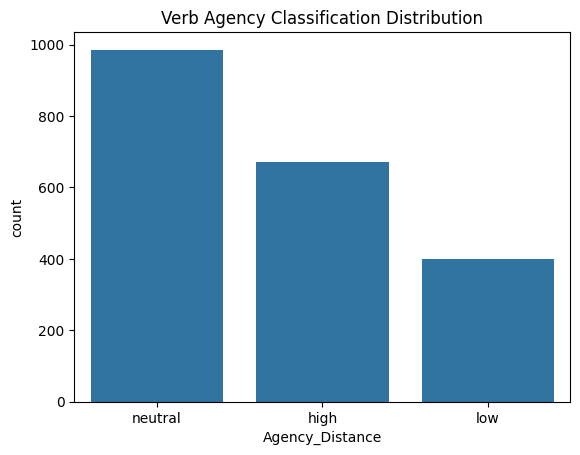

In [146]:
sns.countplot(data=df_pairs, x="Agency_Distance")
plt.title("Verb Agency Classification Distribution")
plt.show()

The distribution of agency labels assigned using the distance-based (vector similarity) method shows us that out of all verbs linked to characters:
- 986 are classified as **neutral**
- 671 as **high-agency**
- 400 as **low-agency**

Compared to the VerbNet-based classification, this method yields a more balanced distribution, with significantly more verbs recognized as high or low agency. This suggests that the distance-based approach captures subtle agency distinctions that symbolic methods miss — especially for verbs that weren’t in the original reference lists.


### Conclusion
Based on the improved distribution and broader coverage, we decide to use the distance-based classification method for the rest of the analysis.

Unlike the VerbNet-based approach, which depends on a fixed set of manually selected verbs, the distance-based method generalizes to any verb in the text by leveraging semantic similarity. This allows us to:
- capture a wider range of actions,
- reduce the number of defaults to "neutral",
- and more accurately reflect the nuance of agency in narrative language.

The higher counts for both high- and low-agency verbs suggest that this method is more sensitive to variation in how characters act — which is exactly what we need for exploring patterns of power, passivity, and control in fiction.



In [147]:
df_pairs

,verb_pairs,Character,Verb,Agency_VerbNet,character_clean,Agency_Distance
2881,"(lady, say)",lady,say,neutral,lady,neutral
2881,"(lady, return)",lady,return,high,lady,high
2881,"(lady, tell)",lady,tell,high,lady,neutral
2881,"(netherfield, take)",netherfield,take,high,netherfield,high
2883,"(elizabeth, say)",elizabeth,say,neutral,elizabeth,neutral
...,...,...,...,...,...,...
3133,"(darcy, begin)",darcy,begin,neutral,darcy,high
3133,"(darcy, give)",darcy,give,high,darcy,low
3133,"(darcy, send)",darcy,send,high,darcy,high
3133,"(darcy, condescend)",darcy,condescend,neutral,darcy,high


## Agency Matrix

With each verb now labeled by agency and linked to a cleaned character name, we’re ready to compute the agency matrix.

This matrix will show, for each character, how many of their associated verbs fall into the high-, low-, or neutral-agency categories.  
It forms the core of our analysis, allowing us to quantify and compare narrative agency across characters based on their actions in the text.


This step filters the `df_pairs` DataFrame to keep only rows where the subject is a **female character**. We use two criteria:

1. The character name contains typical **female titles** like `"she"`, `"mrs"`, `"miss"`, or `"ms"`.
2. The character is among the **top 10 most frequent female names** from `df_char_freq`.

This filtered set (`filtered_female_df`) allows us to focus our agency analysis on female characters only.

In [148]:
df_pairs["character_clean_cleaned"] = (
    df_pairs["character_clean"]
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)  # remove punctuation
    .str.replace(r"\s+", " ", regex=True)     # collapse whitespace
    .str.strip()
)

In [149]:
unique_clean_names = df_pairs["character_clean_cleaned"].dropna().unique()

Select the top 10 most frequently mentioned female characters for inclusion in the agency matrix.

Filters the character frequency table to include only names labeled as `"female"`, then selects the top `10` based on their mention counts.  
The names are lowercased for consistency and indexed cleanly for easier use in downstream matching.


In [150]:
top_n = 10

top_female_characters = (
    df_char_freq[df_char_freq["Gender"] == "female"]
    .sort_values("Count", ascending=False)
    .head(top_n)
    .copy()
)

top_female_characters["Name"] = top_female_characters["Name"].str.lower()
top_female_characters.reset_index(drop=True, inplace=True)
top_female_characters


,Name,Count,Gender
0,elizabeth,307,female
1,jane,131,female
2,mrs. bennet,77,female
3,catherine,73,female
4,miss bingley,43,female
5,kitty,34,female
6,mrs. gardiner,31,female
7,charlotte,26,female
8,miss darcy,23,female
9,mary,22,female


We use `rapidfuzz` to resolve inconsistencies between how character names appear in the text and how they are recorded in our reference list.

In narrative fiction, the same character might be referred to in multiple ways — for example, “elizabeth”, “miss eliza”, and “lizzy” may all refer to the same person. These differences can result from nicknames, titles, or minor formatting issues.

By applying fuzzy matching with `rapidfuzz`, we can automatically link similar strings even when they’re not exact matches. This improves the accuracy of our agency matrix by making sure that all verb references to a character are counted under a single, unified name.


In [151]:
!pip install rapidfuzz

Use fuzzy string matching to align canonical female character names with the versions found in the parsed text.

For each name in `top_female_characters`, we searche for the closest match among the cleaned character names extracted from subject–verb pairs.  
Use `token_set_ratio` from `rapidfuzz`, which is effective for matching unordered or partial name overlaps (e.g., “elizabeth” vs. “miss eliza”).

The results are stored in `fuzzy_match_df`, which includes the original name, the matched name from the text, and a similarity score.  
A threshold of 85 is applied to select strong matches, reducing the risk of mismatching unrelated names.

This step helps unify name variants before building the agency matrix.


In [152]:
from rapidfuzz import process, fuzz
import pandas as pd
matches = []

for female_name in top_female_characters["Name"]:
    match, score, _ = process.extractOne(
        female_name, unique_clean_names, scorer=fuzz.token_set_ratio
    )
    matches.append((female_name, match, score))

In [153]:
fuzzy_match_df = pd.DataFrame(matches, columns=["Female Name", "Matched Name", "Score"])

In [154]:
strong_matches = fuzzy_match_df[fuzzy_match_df["Score"] >= 85]

In [155]:
fuzzy_match_df

,Female Name,Matched Name,Score
0,elizabeth,elizabeth,100.000000
1,jane,jane,100.000000
2,mrs. bennet,jenkinson,40.000000
3,catherine,catherine,100.000000
4,miss bingley,rosings,42.105263
5,kitty,kitty,100.000000
6,mrs. gardiner,gardiner,100.000000
7,charlotte,charlotte,100.000000
8,miss darcy,darcy,100.000000
9,mary,mary,100.000000


In [156]:
strong_matches

,Female Name,Matched Name,Score
0,elizabeth,elizabeth,100.0
1,jane,jane,100.0
3,catherine,catherine,100.0
5,kitty,kitty,100.0
6,mrs. gardiner,gardiner,100.0
7,charlotte,charlotte,100.0
8,miss darcy,darcy,100.0
9,mary,mary,100.0


Create a mapping from the matched character names in the text back to their canonical female names.

The dictionary `match_map` links each matched variant (e.g., `"miss eliza"`) to its standardized name (e.g., `"elizabeth"`).  
This mapping is applied to the cleaned character column to produce `character_resolved`, a new column that consolidates all name variants under a consistent label.

This ensures that all verbs linked to the same character are grouped together, making the agency counts accurate and comparable across individuals.


In [157]:
match_map = dict(zip(strong_matches["Matched Name"], strong_matches["Female Name"]))

df_pairs["character_resolved"] = df_pairs["character_clean_cleaned"].map(match_map)

Construct the agency matrix for the resolved female characters.

It filters the data to include only rows where a character has been successfully resolved, then groups by character and agency label (`"high"`, `"low"`, `"neutral"`).  
The resulting matrix shows the number of verbs in each agency category for every character. `unstack()` reshapes the data so that each row corresponds to a character and each column to an agency level.


In [158]:
agency_matrix = (
    df_pairs[df_pairs["character_resolved"].notna()]
    .groupby(["character_resolved", "Agency_Distance"])
    .size()
    .unstack(fill_value=0)
)

In [159]:
agency_matrix

Agency_Distance,high,low,neutral
character_resolved,,,
catherine,34,12,50
charlotte,27,8,29
elizabeth,300,191,432
jane,59,38,97
kitty,17,6,25
mary,15,3,17
miss darcy,112,61,154
mrs. gardiner,23,20,42


Normalize the agency matrix by row to express each character’s agency distribution as proportions rather than raw counts.

In [160]:
agency_matrix_normalized = agency_matrix.div(agency_matrix.sum(axis=1), axis=0)


Generates a heatmap to visualize the normalized agency distribution for each character.

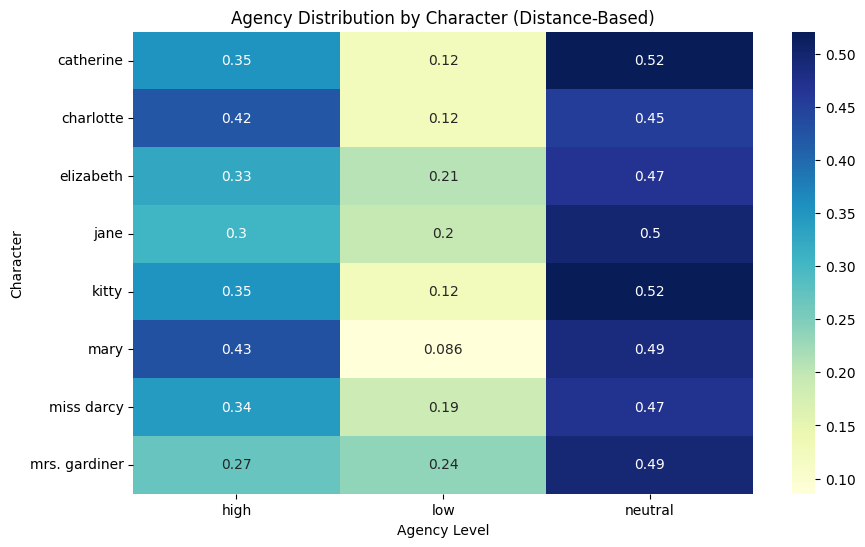

In [161]:
plt.figure(figsize=(10, 6))
sns.heatmap(agency_matrix_normalized, annot=True, cmap="YlGnBu")
plt.title("Agency Distribution by Character (Distance-Based)")
plt.xlabel("Agency Level")
plt.ylabel("Character")
plt.show()


This heatmap shows the normalized distribution of agency levels — high, low, and neutral — for the top female characters in *Pride and Prejudice*. Each row represents a character, and each column indicates the proportion of verbs associated with that agency level. All values are normalized per character, so the rows sum to 1. This allows for a fair comparison of agency profiles regardless of how often each character appears in the text.

#### Interpretation:
- Most characters are dominated by **neutral verbs**, which is expected given the narrative structure of the novel.
- **Charlotte** and **Mary** show the highest relative proportion of **high-agency** verbs (42–43%), suggesting that their appearances are often action-driven despite having fewer total mentions.
- **Elizabeth**, while central to the plot, shows a **more balanced profile**, with one-third high-agency and one-fifth low-agency — implying narrative involvement that’s not overly active or passive.
- **Jane**, **Miss Darcy**, and **Catherine** all show relatively similar profiles, skewing more neutral, with modest use of both high- and low-agency verbs.

This visualization allows us to compare how characters are portrayed through language — not just by how often they appear, but by what kinds of actions they are given. It’s a structured lens on literary agency and a first step toward broader character analysis across texts.


### Conclusion

This notebook presents a full pipeline for analyzing narrative agency in historical fiction using Natural Language Processing. Starting from raw text chunks, we extracted subject–verb structures, resolved character identities, and assigned agency labels to verbs based on both symbolic and semantic methods.

By focusing on *Pride and Prejudice* as a case study, we were able to:
- Clean and normalize character references,
- Classify verbs into high-, low-, and neutral-agency categories using vector-based similarity,
- Align character mentions with canonical names through fuzzy matching,
- And build an agency matrix to quantify how each character is portrayed in terms of action and power.

The final visualizations highlight subtle differences in agency distribution among key female characters, offering a structured way to explore literary patterns of gender, power, and voice.

This approach can now be scaled to additional texts in the dataset, enabling broader comparative analysis across time periods, authors, and genres — and supporting a deeper understanding of how women’s agency is encoded and expressed in fiction.


# THE AWAKENING

For the next phase of analysis, we focus on *The Awakening* by Kate Chopin.

This novel is a strong follow-up to *Pride and Prejudice* because it deals explicitly with themes of gender, autonomy, and selfhood — but from a later, more modernist perspective. Unlike Austen’s restrained third-person narration, Chopin’s writing follows a more internal, psychologically driven style that allows us to track shifts in agency over time within a single protagonist.

The central character, Edna Pontellier, undergoes a complex transformation as she challenges the expectations placed on her as a wife and mother. This makes *The Awakening* an ideal text for studying how linguistic agency reflects — and sometimes resists — traditional gender roles.

It also provides a contrast in both narrative voice and ideological context, helping test how well our method generalizes across different styles and historical moments in women’s fiction.


In [162]:
df_aw = df[df["title"] == "The Awakening"].copy()

In [163]:
df_aw.head(20)

,chunk,title,author,year,chunk_id
3134,"I A green and yellow parrot, which hung in a c...",The Awakening,Kate Chopin,1899,KC_001
3135,Mr. Pontellier finally lit a cigar and began t...,The Awakening,Kate Chopin,1899,KC_002
3136,Both children wanted to follow their father wh...,The Awakening,Kate Chopin,1899,KC_003
3137,"She was an\nAmerican woman, with a small infus...",The Awakening,Kate Chopin,1899,KC_004
3138,He himself had his hands full with his brokera...,The Awakening,Kate Chopin,1899,KC_005
3139,The following morning Mr. Pontellier was up in...,The Awakening,Kate Chopin,1899,KC_006
3140,The quadroon nurse was looked upon as a huge e...,The Awakening,Kate Chopin,1899,KC_007
3141,But she did not want to appear unamiable and u...,The Awakening,Kate Chopin,1899,KC_008
3142,They formed a congenial group sitting there th...,The Awakening,Kate Chopin,1899,KC_009
3143,She liked the\ndabbling. She felt in it satisf...,The Awakening,Kate Chopin,1899,KC_010


In [164]:
df_aw["person_names"] = df_aw["chunk"].apply(extract_names_with_titles)

In [165]:
df_aw.head(20)

,chunk,title,author,year,chunk_id,person_names
3134,"I A green and yellow parrot, which hung in a c...",The Awakening,Kate Chopin,1899,KC_001,"[Mr. Pontellier, Lebrun, Madame Lebrun, Mr. Po..."
3135,Mr. Pontellier finally lit a cigar and began t...,The Awakening,Kate Chopin,1899,KC_002,"[Mr. Pontellier, gaunt, Mrs. Pontellier, Rober..."
3136,Both children wanted to follow their father wh...,The Awakening,Kate Chopin,1899,KC_003,"[Mrs. Pontellier, Robert, Mrs. Pontellier, Rob..."
3137,"She was an\nAmerican woman, with a small infus...",The Awakening,Kate Chopin,1899,KC_004,"[Robert, Mrs. Pontellier, Léonce, Robert, Klei..."
3138,He himself had his hands full with his brokera...,The Awakening,Kate Chopin,1899,KC_005,"[Mrs. Pontellier, Mrs. Pontellier, Mrs. Pontel..."
3139,The following morning Mr. Pontellier was up in...,The Awakening,Kate Chopin,1899,KC_006,"[Mr. Pontellier, Mr. Pontellier, Klein, Janet,..."
3140,The quadroon nurse was looked upon as a huge e...,The Awakening,Kate Chopin,1899,KC_007,"[Mrs. Pontellier, Adèle, Mrs. Pontellier, Mrs...."
3141,But she did not want to appear unamiable and u...,The Awakening,Kate Chopin,1899,KC_008,"[Robert, Madame Ratignolle, Robert, Mrs. Ponte..."
3142,They formed a congenial group sitting there th...,The Awakening,Kate Chopin,1899,KC_009,"[Robert, Mrs. Pontellier, Robert, Mrs. Pontell..."
3143,She liked the\ndabbling. She felt in it satisf...,The Awakening,Kate Chopin,1899,KC_010,"[Madame Ratignolle, sensuous Madonna, Robert, ..."


In [166]:
df_aw["person_names_cleaned"] = df_aw["person_names"].apply(
    lambda names: list(set(normalize_name_with_title(n) for n in names))
)

In [167]:
df_aw["person_names_cleaned"].explode().value_counts().head(100)

,count
person_names_cleaned,
Edna,86
Robert,57
Mrs. Pontellier,42
Mr. Pontellier,30
Mademoiselle Reisz,24
...,...
Quartier Français,1
gaunt,1
Angostura,1


In [168]:
char_counter = Counter()
for names in df_aw["person_names_cleaned"]:
    char_counter.update(names)

df_char_freq_aw = pd.DataFrame(char_counter.items(), columns=["Name", "Count"]).sort_values("Count", ascending=False)


In [169]:
df_char_freq_aw.head(20)

,Name,Count
8,Edna,86
5,Robert,57
6,Mrs. Pontellier,42
2,Mr. Pontellier,30
43,Mademoiselle Reisz,24
18,Madame Ratignolle,20
0,Madame Lebrun,19
47,Mademoiselle,15
40,Victor,14
82,Arobin,13


In [170]:
df_char_freq_aw = df_char_freq_aw[df_char_freq_aw["Name"].apply(is_valid_character)].copy()

In [171]:
df_char_freq_aw

,Name,Count
8,Edna,86
5,Robert,57
6,Mrs. Pontellier,42
2,Mr. Pontellier,30
43,Mademoiselle Reisz,24
...,...,...
167,Janie,1
169,Nick,1
168,Ned,1
172,cabriolet,1


In [172]:
name_map_awakening = {
    # Main character
    "edna": "Edna Pontellier",
    "mrs pontellier": "Edna Pontellier",
    "madame pontellier": "Edna Pontellier",

    # Love interest
    "robert": "Robert Lebrun",
    "mr robert": "Robert Lebrun",
    "lebrun": "Robert Lebrun",
    "robert lebrun": "Robert Lebrun",

    # Husband
    "mr pontellier": "Leonce Pontellier",
    "leonce pontellier": "Leonce Pontellier",
    "monsieur pontellier": "Leonce Pontellier",

    # Close friend
    "madame ratignolle": "Adele Ratignolle",
    "adele": "Adele Ratignolle",
    "mrs ratignolle": "Adele Ratignolle",

    # Piano player
    "mademoiselle reisz": "Mademoiselle Reisz",
    "reisz": "Mademoiselle Reisz",

    # Others to consider (as they appear often)
    "alcee arobin": "Alee Arobin",
    "arobin": "Alcee Arobin",
    "victor lebrun": "Victor Lebrun",
    "dr mandelet": "Doctor Mandelet",
    "governor": "Governor",
}

In [173]:
df_char_freq_aw["Name"] = df_char_freq_aw["Name"].replace(name_map_awakening)

In [174]:
df_char_freq_aw = (
    df_char_freq_aw.groupby("Name", as_index=False)
    .agg({"Count": "sum"})
    .sort_values("Count", ascending=False)
)

In [175]:
df_char_freq_aw

,Name,Count
34,Edna,86
138,Robert,57
119,Mrs. Pontellier,42
109,Mr. Pontellier,30
82,Mademoiselle Reisz,24
...,...,...
166,mon bébé,1
168,sally,1
169,sensuous Madonna,1
171,solicitously,1


In [176]:
df_char_freq_aw["Gender"] = df_char_freq_aw["Name"].apply(infer_gender_from_title)

In [177]:
df_char_freq_aw

,Name,Count,Gender
34,Edna,86,None
138,Robert,57,None
119,Mrs. Pontellier,42,female
109,Mr. Pontellier,30,male
82,Mademoiselle Reisz,24,female
...,...,...,...
166,mon bébé,1,None
168,sally,1,None
169,sensuous Madonna,1,None
171,solicitously,1,None
